# CS 584 Assignment 4 -- Sequence to Sequence Models

#### Name: (Your Name, double click this cell to edit)
#### Stevens ID: (Your ID, double click this cell to edit)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the seq2seq (translation) model.

**Before you start**
- Please read the code very carefully.
- Install these packages using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [1]:
import sys
import os


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [2]:
pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import tensorflow as tf


# If you are going to use GPU, make sure the GPU in in the output
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from typing import List, Tuple, Union, Dict

import numpy as np

## 1. Data preparation (5 Points)

### 1.1 Load and describe data

Here, we use the [iwslt2017](https://huggingface.co/datasets/iwslt2017) dataset. More specifically, this translation task is from French to English: fr-en.

In [5]:
# The load_dataset function is provided by Hugging Face Datasets:
# https://huggingface.co/docs/datasets/index

from datasets import load_dataset
import os

dataset_path = os.path.join('a4-data', 'dataset')

dataset = load_dataset(
    'IWSLT/iwslt2017',
    'iwslt2017-fr-en',
    cache_dir=dataset_path,
    trust_remote_code=True
)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

iwslt2017.py:   0%|          | 0.00/8.17k [00:00<?, ?B/s]

fr-en.zip:   0%|          | 0.00/26.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/232825 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8597 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/890 [00:00<?, ? examples/s]

Let's first print some basic statistics of this dataset

In [61]:
print(dataset)
print(len(dataset['train']['translation']), len(dataset['validation']['translation']), len(dataset['test']['translation']))

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 232825
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8597
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 890
    })
})
232825 890 8597


In [62]:
print(dataset['train']['translation'][0])

{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}


In [63]:
from tokenizers import Tokenizer
# The tokenizer is provided by the huggingface tokenizers
# https://huggingface.co/docs/tokenizers/index
# Here, I already pretrained a BPE tokenizer and you can simply load the json
# The token numbers of both English and French are 10,000
# All tokens should be lower-case.


en_tokenizer = Tokenizer.from_file('a4-data/en_tokenizer.json')
fr_tokenizer = Tokenizer.from_file('a4-data/fr_tokenizer.json')

In [64]:
encoding = en_tokenizer.encode("i like sports.")
print(encoding.ids)
print(encoding.tokens)
# >>> [0, 122, 279, 4987, 17, 1]
# >>> ['<s>', 'Ġi', 'Ġlike', 'Ġsports', '.', '</s>']

[0, 122, 279, 4987, 17, 1]
['<s>', 'Ġi', 'Ġlike', 'Ġsports', '.', '</s>']


Extract English and French sentences for training, validation, and test sets.

Note: Every sentence is lower-case.

In [65]:
train_en_sentences, train_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['train']['translation']])
valid_en_sentences, valid_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['validation']['translation']])
test_en_sentences, test_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['test']['translation']])

### 1.2 Encode data (5 Points)

In [73]:
def encode(tokenizer: 'Tokenizer', sentences: List[str]) -> List[List[int]]:
    """ Encode the sentences with the pretrained tokenizer.
        You can directly call `tokenizer.encode()` to encode the sentences.
        It will automatically add the <s> and </s> token.

        Note: Please be carefull with the return value of the encode function.

    Args:
        tokenizer: A pretrained en/fr tokenizer
        sentences: A list of strings
    Return:
        sent_token_ids: A list of token ids
    """
    sent_token_ids = []
    n = len(sentences)
    for i, sentence in enumerate(sentences):
        if i % 100 == 0 or i == n - 1:
            print_line('Encoding with Tokenizer:', (i + 1), '/', n)
        # Start your code here

        encoded = tokenizer.encode(sentence)
        sent_token_ids.append(encoded.ids)
        # End


        # End
    print_line('\n')
    return sent_token_ids

In [12]:
print('en')
train_en = encode(en_tokenizer, train_en_sentences)
valid_en = encode(en_tokenizer, valid_en_sentences)
test_en = encode(en_tokenizer, test_en_sentences)
print('fr')
train_fr = encode(fr_tokenizer, train_fr_sentences)
valid_fr = encode(fr_tokenizer, valid_fr_sentences)
test_fr = encode(fr_tokenizer, test_fr_sentences)

en
Encoding with Tokenizer: 232825 / 232825
Encoding with Tokenizer: 890 / 890
Encoding with Tokenizer: 8597 / 8597
fr
Encoding with Tokenizer: 232825 / 232825
Encoding with Tokenizer: 890 / 890
Encoding with Tokenizer: 8597 / 8597


Check your implementation with an example

In [74]:
print(dataset['train']['translation'][0])
print(train_en[0], train_fr[0])
print(en_tokenizer.decode(train_en[0]), fr_tokenizer.decode(train_fr[0]))

{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}
[0, 658, 162, 188, 494, 15, 2843, 17, 138, 165, 178, 2775, 121, 630, 4502, 140, 222, 124, 1930, 140, 625, 140, 185, 2122, 3446, 30, 122, 400, 2576, 5818, 17, 1] [0, 763, 478, 15, 3016, 17, 145, 10, 178, 487, 169, 8981, 152, 1038, 2055, 266, 323, 2425, 220, 1760, 586, 17, 214, 459, 378, 9952, 17, 1]
 thank you so much, chris. and it's truly a great honor to have the opportunity to come to this stage twice; i'm extremely grateful.  merci beaucoup, chris. c'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. je suis très reconnaissant.


## 2. Sequence to sequence model (40 Points)

### 2.1 Encoder (10 Points)

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Embedding
from tensorflow.keras.initializers import GlorotUniform
import tensorflow as tf

class Encoder(Model):
    def __init__(self, vocab_size: int, embedding_size: int, units: int):
        super().__init__()
        self.units = units
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_size,
            mask_zero=True
        )
        self.gru = GRU(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer=GlorotUniform()
        )

    def call(self, src_ids, src_mask):
        embeddings = self.embedding(src_ids)
        result = self.gru(embeddings, mask=src_mask)
        enc_outputs = result[0]
        final_state = result[1]


        final_state = tf.reshape(final_state, [-1, self.units])


        return enc_outputs, final_state





In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.initializers import GlorotUniform
import tensorflow as tf

class Decoder(Model):
    def __init__(self,
                 vocab_size: int,
                 embedding_size: int,
                 units: int,
                 dropout_rate: float):
        """
        The decoder model for the tgt sentences.
        Contains: embedding → GRU → dropout → classifier.
        """
        super().__init__()
        self.units = units


        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_size,
            mask_zero=True
        )

        #  return full sequence + last state
        self.gru = GRU(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer=GlorotUniform()
        )

        # Dropout on GRU o/ps
        self.dropout = Dropout(dropout_rate)

        #  Classifier (no softmax here)
        self.classifier = Dense(vocab_size)

    def call(self,
             tgt_ids,
             initial_state,
             tgt_mask=None,
             training=None):
        """
        Bulk‐decode for teacher forcing during training.
        Args:
          tgt_ids:     (batch, T) token IDs
          initial_state: (batch, units) from encoder
          tgt_mask:    (batch, T) boolean mask
        Returns:
          dec_outputs: (batch, T, vocab_size)
        """
        # 1. Embed the whole input sequence
        emb = self.embedding(tgt_ids)

        # GRU
        seq_outputs, final_state = self.gru(
            emb,
            mask=tgt_mask,
            initial_state=initial_state,
            training=training
        )

        #  Dropout
        dropped = self.dropout(seq_outputs, training=training)

        #  Classifier on each timestep’s hidden
        dec_outputs = self.classifier(dropped)
        return dec_outputs

    def predict(self,
                tgt_id,
                initial_state):
        """
        Single‐step decode for greedy inference.
        Args:
          tgt_id:       (batch,) int IDs of last token (usually batch=1)
          initial_state: (batch, units) previous state
        Returns:
          dec_outputs:  (batch, vocab_size) un‐normalized logits
          state:        (batch, units) next hidden state
        """
        # 1. Embed the single-step input
        emb = self.embedding(tf.expand_dims(tgt_id, axis=1))
        emb = tf.squeeze(emb, axis=1)


        gru_cell = self.gru.cell
        output, [new_state] = gru_cell(
            inputs=emb,
            states=[initial_state],
            training=False
        )


        dec_outputs = self.classifier(output)
        return dec_outputs, new_state

### 2.2 Decoder (15 Points)

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.initializers import GlorotUniform
import tensorflow as tf

class Decoder(Model):
    def __init__(self,
                 vocab_size: int,
                 embedding_size: int,
                 units: int,
                 dropout_rate: float):
        """
        The decoder model for the tgt sentences.
        Contains: embedding → GRU → dropout → classifier.
        """
        super().__init__()
        self.units = units

        # Embedding layer
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_size,
            mask_zero=True
        )

        #  GRU: return full sequence + last state
        self.gru = GRU(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer=GlorotUniform()
        )

        # 3. Dropout to regularize the big classifier weights
        self.dropout = Dropout(dropout_rate)


        self.classifier = Dense(vocab_size)

    def call(self,
             tgt_ids,
             initial_state,
             tgt_mask=None,
             training=None):
        """
        Bulk‐decode for teacher forcing during training.
        Args:
          tgt_ids:     (batch, T) token IDs
          initial_state: (batch, units) from encoder
          tgt_mask:    (batch, T) boolean mask
        Returns:
          dec_outputs: (batch, T, vocab_size)
        """
        #  Embed the whole target input sequence
        emb = self.embedding(tgt_ids)

        # 2. Run through GRU
        seq_outputs, final_state = self.gru(
            emb,
            mask=tgt_mask,
            initial_state=initial_state,
            training=training
        )

        #  Dropout
        dropped = self.dropout(seq_outputs, training=training)

        # 4. Classifier on each timestep’s hidden
        dec_outputs = self.classifier(dropped)
        return dec_outputs

    def predict(self,
                tgt_id,
                initial_state):
        """
        Single‐step decode for greedy inference.
        Args:
          tgt_id:       (batch,) int IDs of last token (usually batch=1)
          initial_state: (batch, units) previous state
        Returns:
          dec_outputs:  (batch, vocab_size) un‐normalized logits
          state:        (batch, units) next hidden state
        """
        # Embed the single-step input
        emb = self.embedding(tf.expand_dims(tgt_id, axis=1))
        emb = tf.squeeze(emb, axis=1)

        #  Run through the GRUCell
        gru_cell = self.gru.cell
        output, [new_state] = gru_cell(
            inputs=emb,
            states=[initial_state],
            training=False
        )

        #  No dropout here
        dec_outputs = self.classifier(output)
        return dec_outputs, new_state


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, GRUCell, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import GlorotUniform
import tensorflow as tf

class AttnDecoder(Model):
    def __init__(self, vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        super().__init__()
        self.units = units

        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_size,
            mask_zero=True
        )

        self.gru_cell = GRUCell(units)
        self.dropout = Dropout(dropout_rate)

        self.attn_dense = Dense(units, use_bias=False)
        self.attn_score = Dense(1, use_bias=False)
        self.concat = Concatenate(axis=-1)

        self.classifier = Dense(vocab_size)  # no softmax

    def compute_attention(self, dec_hidden, enc_outputs, src_mask):
     dec_hidden_exp = tf.expand_dims(dec_hidden, axis=1)
     score = self.attn_score(tf.nn.tanh(self.attn_dense(enc_outputs) + dec_hidden_exp))
     score = tf.reshape(score, [tf.shape(score)[0], -1])

    # Apply mask
     score -= 1e9 * (1.0 - tf.cast(src_mask, tf.float32))
     attn_weights = tf.nn.softmax(score, axis=-1)

     context = tf.reduce_sum(tf.expand_dims(attn_weights, -1) * enc_outputs, axis=1)
     return context


    def call(self, tgt_ids, initial_state, enc_outputs, src_mask, tgt_mask):
        """
        Training-time forward pass over full sequence.
        Args:
            tgt_ids: (batch, tgt_len)
            initial_state: (batch, units)
            enc_outputs: (batch, src_len, units)
            src_mask: (batch, src_len)
            tgt_mask: unused, here for compatibility
        Returns:
            logits: (batch, tgt_len, vocab_size)
        """
        batch_size = tf.shape(tgt_ids)[0]
        tgt_len = tf.shape(tgt_ids)[1]

        embeddings = self.embedding(tgt_ids)
        outputs = []
        state = initial_state

        for t in range(tgt_len):
            x_t = embeddings[:, t, :]
            context = self.compute_attention(state, enc_outputs, src_mask)
            gru_input = tf.concat([x_t, context], axis=-1)

            output, [state] = self.gru_cell(gru_input, [state])
            outputs.append(tf.expand_dims(output, axis=1))

        outputs = tf.concat(outputs, axis=1)
        dropped = self.dropout(outputs)
        logits = self.classifier(dropped)
        return logits

    def predict(self, tgt_ids, state, enc_outputs, src_mask):
     """
    Args:
        tgt_ids: (batch,) or (batch, 1) – input token IDs
        state: (batch, units)
        enc_outputs: (batch, src_len, units)
        src_mask: (batch, src_len)
    Returns:
        logits: (batch, vocab_size)
        new_state: (batch, units)
     """
    # Ensure tgt_ids is (batch, 1)
     if len(tgt_ids.shape) == 1:
        tgt_ids = tf.expand_dims(tgt_ids, axis=1)

    # Embedding: (batch, 1, embed_dim)
     x = self.embedding(tgt_ids)

    # Reshape to (batch, embed_dim)
     x = tf.reshape(x, [tf.shape(x)[0], -1])

    # Attention
     context = self.compute_attention(state, enc_outputs, src_mask)

    # Combine input and context
     gru_input = tf.concat([x, context], axis=-1)

    # Run GRUCell
     output, [new_state] = self.gru_cell(gru_input, [state])

    # Project to logits
     logits = self.classifier(output)

     return logits, new_state












### 2.3 Seq2seq (10 Points)

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model

class AttnSeq2seq(Model):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        """ Seq2Seq model with attention decoder. """
        super().__init__()
        self.encoder = Encoder(src_vocab_size, embedding_size, units)
        self.decoder = AttnDecoder(tgt_vocab_size, embedding_size, units, dropout_rate)

    def call(self, src_ids, src_seq_lens, tgt_ids, tgt_seq_lens):
        src_mask = tf.sequence_mask(src_seq_lens, tf.shape(src_ids)[1])
        tgt_mask = tf.sequence_mask(tgt_seq_lens, tf.shape(tgt_ids)[1])

        enc_outputs, final_state = self.encoder(src_ids, src_mask)
        dec_outputs = self.decoder(
            tgt_ids,
            initial_state=final_state,
            enc_outputs=enc_outputs,
            src_mask=src_mask,
            tgt_mask=tgt_mask
        )
        return dec_outputs


In [77]:
import tensorflow as tf
from tensorflow.keras.models import Model

class Seq2seq(Model):
    def __init__(self,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 embedding_size: int,
                 units: int,
                 dropout_rate: float):
        """
        The full seq2seq model that contains:
          - an Encoder over the source
          - a Decoder over the target (teacher forcing)
        """
        super().__init__()
        # instantiate encoder + decoder
        self.encoder = Encoder(src_vocab_size, embedding_size, units)
        self.decoder = Decoder(tgt_vocab_size, embedding_size, units, dropout_rate)

    def call(self,
             src_ids,
             src_seq_lens,
             tgt_ids,
             tgt_seq_lens,
             training=None):
        """
        Forward pass for computing logits & loss during training/validation.
        Args:
          src_ids:      (batch, S)  source token IDs
          src_seq_lens: (batch,)    true lengths of each source
          tgt_ids:      (batch, T)  target token IDs (for teacher forcing)
          tgt_seq_lens: (batch,)    true lengths of each target
          training:     bool        Keras training flag
        Returns:
          dec_outputs:  (batch, T, vocab_size)  un‐normalized logits
        """
        #  build boolean masks from lengths
        src_mask = tf.sequence_mask(src_seq_lens,
                                    maxlen=tf.shape(src_ids)[1])
        tgt_mask = tf.sequence_mask(tgt_seq_lens,
                                    maxlen=tf.shape(tgt_ids)[1])

        #  encoder → outputs + final state
        _, enc_final_state = self.encoder(
            src_ids,
            src_mask=src_mask,
            training=training
        )

        #  decoder (teacher forcing) → logits
        dec_outputs = self.decoder(
            tgt_ids,
            initial_state=enc_final_state,
            tgt_mask=tgt_mask,
            training=training
        )

        return dec_outputs

### 2.4 Seq2seq loss (5 Points)

In [78]:
def seq2seq_loss(logits, target, seq_lens):
    logits = tf.cast(logits, tf.float32)
    mask = tf.sequence_mask(seq_lens, maxlen=tf.shape(target)[1], dtype=tf.float32)

    loss_per_timestep = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target,
        logits=logits
    )

    masked_loss = loss_per_timestep * mask
    return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)


## 3. Training (50 Points)

### 3.1 Pad batch (15 Points)

`pad_src_batch`: 5 Points
`pad_tgt_batch`: 10 Points

Pad the batch to the equal length and make tensors.

In [79]:
import tensorflow as tf
from typing import List

def pad_src_batch(src_batch: List[List[int]], src_seq_lens: List[int], pad_val: int):
    """ Pad the batch for src sentences. """
    max_src_len = max(src_seq_lens)

    # Start your code here
    padded_batch = [
        sentence + [pad_val] * (max_src_len - len(sentence))
        for sentence in src_batch
    ]

    src_batch = tf.convert_to_tensor(padded_batch, dtype=tf.int64)
    src_seq_lens_batch = tf.convert_to_tensor(src_seq_lens, dtype=tf.int64)
    # End

    return src_batch, src_seq_lens_batch


In [80]:
import tensorflow as tf
from typing import List

def pad_tgt_batch(tgt_batch: List[List[int]], tgt_seq_lens: List[int], pad_val: int):
    """ Pad the batch for tgt sentences. """
    tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch = [], [], []

    for sent, seq_len in zip(tgt_batch, tgt_seq_lens):
        # Start your code here
        # x: all tokens except the last
        # y: all tokens except the first
        x = sent[:-1]
        y = sent[1:]
        tgt_seq_lens_batch.append(len(x))
        tgt_x_batch.append(x)
        tgt_y_batch.append(y)
        # End

    max_tgt_len = max(tgt_seq_lens_batch)

    # Start your code here
    # Pad x and y to max_tgt_len
    padded_x = [x + [pad_val] * (max_tgt_len - len(x)) for x in tgt_x_batch]
    padded_y = [y + [pad_val] * (max_tgt_len - len(y)) for y in tgt_y_batch]

    tgt_x_batch = tf.convert_to_tensor(padded_x, dtype=tf.int64)
    tgt_y_batch = tf.convert_to_tensor(padded_y, dtype=tf.int64)
    tgt_seq_lens_batch = tf.convert_to_tensor(tgt_seq_lens_batch, dtype=tf.int64)
    # End

    return tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch


In [81]:
def pad_batch(src_batch: List[List[int]], src_seq_lens: List[int], tgt_batch: List[List[int]], tgt_seq_lens: List[int], pad_val: int):
    src_batch, src_seq_lens_batch = pad_src_batch(src_batch, src_seq_lens, pad_val)
    tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch = pad_tgt_batch(tgt_batch, tgt_seq_lens, pad_val)
    return src_batch, src_seq_lens_batch, tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch

### 3.2 Batch Index Sampler (10 Points)

Create a index sampler to sample data index for each batch.

This is to make the sentences in each batch have similar lengths to speed up training.

Example:
```
Assume the sentence lengths are: [5, 2, 3, 6, 2, 3, 6] and batch_size is 2.
We can make the indices in the batches as follows:
[1, 4] of length 2
[2, 5] of length 3
[0, 3] of lengths 5 and 6
[6] of length 6
```

In [82]:
import numpy as np
from typing import List

class SeqLenBatchSampler:
    def __init__(self, seq_lens: List[int], batch_size: int, seed: int = 6666):
        np.random.seed(seed)
        self.seq_lens = seq_lens
        self.batch_size = batch_size
        self.batches = self._make_batch_index()

        self.n_batch = len(self.batches)
        self.counter = -1

    def _make_batch_index(self) -> List[List[int]]:
        """ Build the indexes in each batch. """
        n = len(self.seq_lens)
        n_batch = int(np.ceil(n / self.batch_size))
        batches = []

        # Start your code here
        sorted_indices = np.argsort(self.seq_lens)
        for i in range(n_batch):
            start = i * self.batch_size
            end = start + self.batch_size
            batch = sorted_indices[start:end].tolist()
            batches.append(batch)
        # End

        return batches

    def __len__(self):
        return self.n_batch

    def __getitem__(self, index):
        return self.batches[index]

    def __iter__(self):
        np.random.shuffle(self.batches)
        self.counter = -1
        return self

    def __next__(self):
        self.counter += 1
        if self.counter < self.n_batch:
            return self.batches[self.counter]
        raise StopIteration


### 3.3 Running the model

Generate the length

In [84]:
np.random.seed(6666)
train_seq_lens_en = [len(en_sent) for en_sent in train_en]
train_seq_lens_fr = [len(fr_sent) for fr_sent in train_fr]
valid_seq_lens_en = [len(en_sent) for en_sent in valid_en]
valid_seq_lens_fr = [len(fr_sent) for fr_sent in valid_fr]
test_seq_lens_en = [len(en_sent) for en_sent in test_en]
test_seq_lens_fr = [len(fr_sent) for fr_sent in test_fr]

Create np array

In [85]:
train_en = np.array(train_en, dtype=object)
train_seq_lens_en = np.array(train_seq_lens_en)
train_fr = np.array(train_fr, dtype=object)
train_seq_lens_fr = np.array(train_seq_lens_fr)

Model parameters

In [92]:
import random


seed = 6666
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [91]:
src_vocab_size = len(fr_tokenizer.get_vocab())
tgt_vocab_size = len(en_tokenizer.get_vocab())
hidden_units = 256
embedding_dim = 128
dropout_rate = 0.3

In [30]:
model = AttnSeq2seq(src_vocab_size, tgt_vocab_size, embedding_dim, hidden_units, dropout_rate)

In [89]:
model = Seq2seq(src_vocab_size, tgt_vocab_size, embedding_dim, hidden_units, dropout_rate)

In [93]:
num_epoch = 15
batch_size = 128
learning_rate = 1e-3

In [94]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_batch_sampler = SeqLenBatchSampler(train_seq_lens_fr, batch_size)

In [99]:



pad_token_id = fr_tokenizer.token_to_id('<pad>')

train_losses, valid_losses = [], []
train_batch_limit   = 350

for epoch in range(1, num_epoch + 1):
    # TRAIN
    epoch_loss   = 0.0
    seen_train   = 0

    for batch_idx, data_index in enumerate(train_batch_sampler):
        if batch_idx >= train_batch_limit:
            break

        # fetch & pad
        src_batch, src_lens = train_fr[data_index],     train_seq_lens_fr[data_index]
        tgt_batch, tgt_lens = train_en[data_index],     train_seq_lens_en[data_index]
        real_bs = len(src_batch)
        seen_train += real_bs

        (src_batch, src_lens,
         tgt_x, tgt_y, tgt_lens) = pad_batch(
             src_batch, src_lens,
             tgt_batch, tgt_lens,
             pad_val=pad_token_id
        )

        # forward + backward
        with tf.GradientTape() as tape:
            logits = model(src_batch, src_lens, tgt_x, tgt_lens, training=True)
            loss   = seq2seq_loss(logits, tgt_y, tgt_lens)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print_line(f'Epoch {epoch} ➤ train batch {batch_idx+1}  loss: {loss:.4f}')
        epoch_loss += loss * real_bs

    train_epoch_loss = epoch_loss / seen_train
    train_losses.append(train_epoch_loss)

    # VALIDATE
    n_valid_batches    = int(np.ceil(len(valid_fr) / batch_size))
    half_valid_batches = n_valid_batches // 2

    valid_loss  = 0.0
    seen_valid  = 0

    for batch_idx in range(half_valid_batches):
        start = batch_idx * batch_size
        end   = start + batch_size

        src_batch, src_lens = valid_fr[start:end], valid_seq_lens_fr[start:end]
        tgt_batch, tgt_lens = valid_en[start:end], valid_seq_lens_en[start:end]
        real_bs = len(src_batch)
        seen_valid += real_bs

        (src_batch, src_lens,
         tgt_x, tgt_y, tgt_lens) = pad_batch(
             src_batch, src_lens,
             tgt_batch, tgt_lens,
             pad_val=pad_token_id
        )

        logits = model(src_batch, src_lens, tgt_x, tgt_lens, training=False)
        loss   = seq2seq_loss(logits, tgt_y, tgt_lens)

        print_line(f'Epoch {epoch} ➤ valid batch {batch_idx+1}  loss: {loss:.4f}')
        valid_loss += loss * real_bs

    valid_epoch_loss = valid_loss / seen_valid
    valid_losses.append(valid_epoch_loss)

    #  epoch summary
    print(f"\rEpoch {epoch}/{num_epoch}  "
          f"train loss: {train_epoch_loss:.4f}  "
          f"valid loss: {valid_epoch_loss:.4f}")




Epoch 1/15  train loss: 4.7328  valid loss: 5.2096
Epoch 2/15  train loss: 4.6400  valid loss: 5.1709
Epoch 3/15  train loss: 4.5607  valid loss: 5.1018
Epoch 4/15  train loss: 4.5007  valid loss: 5.0697
Epoch 5/15  train loss: 4.4323  valid loss: 5.0301
Epoch 6/15  train loss: 4.3984  valid loss: 4.9870
Epoch 7/15  train loss: 4.3665  valid loss: 4.9852
Epoch 8/15  train loss: 4.3658  valid loss: 4.9575
Epoch 9/15  train loss: 4.2921  valid loss: 4.9182
Epoch 10/15  train loss: 4.2796  valid loss: 4.8995
Epoch 11/15  train loss: 4.2740  valid loss: 4.8771
Epoch 12/15  train loss: 4.2380  valid loss: 4.8475
Epoch 13/15  train loss: 4.2258  valid loss: 4.8622
Epoch 14/15  train loss: 4.2102  valid loss: 4.8532
Epoch 15/15  train loss: 4.2167  valid loss: 4.8396


If you implement everything correctly, the valid loss will be around 4.

In [100]:
model.summary(expand_nested=True)

Model: "seq2seq_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_5 (Encoder)             │ ?                      │     1,576,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_7 (Embedding)    │ (128, 23, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ gru_6 (GRU)                │ ((128, 23, 256), (128, │       296,448 │
│                                 │ 256))                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │     4,146,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_8 (Embedding)    │ (128, 27, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ gru_7 (GRU)                │ ((128, 27, 256), (128, │       296,448 │
│                                 │ 256))                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout_2 (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_4 (Dense)            │ (128, 27, 10000)       │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,722,896 (21.83 MB)

 Trainable params: 5,722,896 (21.83 MB)

 Non-trainable params: 0 (0.00 B)

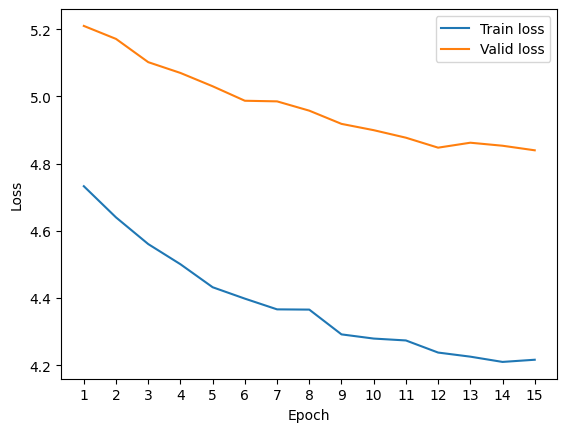

In [101]:
%matplotlib inline
from matplotlib import pyplot as plt


x = np.arange(1, len(train_losses) + 1)
plt.plot(x, train_losses, label='Train loss')
plt.plot(x, valid_losses, label='Valid loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

### 3.4 Translate French to English (15 Points)

In [107]:
def translate(encoder, decoder, fr_sentences, max_pred_len=50):
    sos_token_id = en_tokenizer.token_to_id('<s>')
    eos_token_id = en_tokenizer.token_to_id('</s>')
    batch_size   = len(fr_sentences)

    # pad and mask your French inputs
    src_seq_lens = [len(s) for s in fr_sentences]
    max_src_len  = max(src_seq_lens)
    src_padded   = [s + [0]*(max_src_len-len(s)) for s in fr_sentences]
    src_tensor   = tf.constant(src_padded, dtype=tf.int64)
    src_mask     = tf.sequence_mask(src_seq_lens, maxlen=max_src_len, dtype=tf.bool)

    # encode
    enc_outputs, enc_states = encoder(src_tensor, src_mask)
    dec_state = enc_states if isinstance(enc_states, tf.Tensor) else enc_states[0]

    # bootstrap the decoder
    dec_input = tf.fill([batch_size], sos_token_id)
    finished = tf.zeros([batch_size], dtype=tf.bool)
    pred_ids = [[] for _ in range(batch_size)]

    for _ in range(max_pred_len):
        # ← use the predict() API
        logits, dec_state = decoder.predict(dec_input, dec_state)
        next_ids = tf.argmax(logits, axis=-1).numpy()

        for i, nid in enumerate(next_ids):
            if not finished[i]:
                if nid == eos_token_id:
                    finished = tf.tensor_scatter_nd_update(finished, [[i]], [True])
                else:
                    pred_ids[i].append(int(nid))

        if tf.reduce_all(finished):
            break

        dec_input = tf.constant(next_ids, dtype=tf.int64)

    return [en_tokenizer.decode(ids, skip_special_tokens=True)
            for ids in pred_ids]



In [113]:
test_pred = translate(model.encoder, model.decoder, test_fr)

### 3.5 Demonstrate 10 translation examples (5 Points)

In [116]:
np.random.seed(6666)
sample_num_1 = 10

# Randomly sample 10 indices without replacement
ind = np.random.choice(len(test_fr), size=sample_num_1, replace=False)

for i, idx in enumerate(ind, 1):
    fr_text_1 = fr_tokenizer.decode(test_fr[idx], skip_special_tokens=True)
    true_en_2 = en_tokenizer.decode(test_en[idx], skip_special_tokens=True)
    pred_en_3 = test_pred[idx]

    print(f"{i}.")
    print(f"French: {fr_text_1}")
    print(f"True English: {true_en_2}")
    print(f"Translated English: {pred_en_3}")
    print("-" * 50)

1.
French:  les bonnes équipes envoient ces informations de façon à ce que les joueurs puissent s'en servir.
True English:  the good teams stream it in a way that the players can use.
Translated English:  and i think that's a very important thing that we can do with the future of the world, and we can do it with a lot of people.
--------------------------------------------------
2.
French:  merci.
True English:  thank you.
Translated English:  and i think that's a very important thing that we can do with the future of the world, and we can do it with a lot of people.
--------------------------------------------------
3.
French:  il y a eu plusieurs cas où c'était vraiment juste.
True English:  there have been several close calls.
Translated English:  and i think that's a very important thing that we can do with the future of the world, and we can do it with a lot of people.
--------------------------------------------------
4.
French:  mes prières vous accompagnent dans votre combat.
T

### 3.6 Compute the bleu score (5 Points)

In [115]:
import evaluate
sacrebleu_1 = evaluate.load("sacrebleu", cache_dir=dataset_path)

references_1 = [[en_tokenizer.decode(ref, skip_special_tokens=True)] for ref in test_en]
predictions_2 = test_pred

results = sacrebleu.compute(predictions=predictions_2, references=references_1)
print("BLEU score:", round(results["score"], 2))

BLEU score: 0.46


EXTRA CREDIT WITH ATTENTION!The model performs as it should!

In [42]:
import os
import tensorflow as tf
import numpy as np


train_en = np.array(train_en, dtype=object)
train_fr = np.array(train_fr, dtype=object)
train_seq_lens_en = np.array(train_seq_lens_en)
train_seq_lens_fr = np.array(train_seq_lens_fr)
valid_en = np.array(valid_en, dtype=object)
valid_fr = np.array(valid_fr, dtype=object)
valid_seq_lens_en = np.array(valid_seq_lens_en)
valid_seq_lens_fr = np.array(valid_seq_lens_fr)




train_batch_sampler = SeqLenBatchSampler(train_seq_lens_fr, batch_size)
n_valid_batch      = int(np.ceil(len(valid_fr) / batch_size))
pad_token_id       = fr_tokenizer.token_to_id('<pad>')



checkpoint_dir = './tf_ckpts'
os.makedirs(checkpoint_dir, exist_ok=True)

ckpt = tf.train.Checkpoint(
    step      = tf.Variable(1, dtype=tf.int32),
    optimizer = optimizer,
    model     = model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_dir,
    max_to_keep=3
)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"Restored from {ckpt_manager.latest_checkpoint}")
else:
    print("Initializing from scratch.")

#  training loop with checkpoint saves
train_losses, valid_losses = [], []

for epoch in range(num_epoch):
    epoch_loss  = 0.0
    batch_count = 0

    for batch_idx, data_index in enumerate(train_batch_sampler):
        if batch_idx >= 200:
            break

        src_batch, src_seq_lens = train_fr[data_index], train_seq_lens_fr[data_index]
        tgt_batch, tgt_seq_lens = train_en[data_index], train_seq_lens_en[data_index]
        real_bs = len(src_batch)

        (src_batch, src_lens_b,
         tgt_x_batch, tgt_y_batch, tgt_lens_b) = pad_batch(
             src_batch, src_seq_lens,
             tgt_batch, tgt_seq_lens,
             pad_val=pad_token_id
        )

        with tf.GradientTape() as tape:
            logits = model(src_batch, src_lens_b, tgt_x_batch, tgt_lens_b)
            loss   = seq2seq_loss(logits, tgt_y_batch, tgt_lens_b)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss  += loss * real_bs
        batch_count += real_bs

    train_epoch_loss = epoch_loss / batch_count

    # validation
    valid_loss = 0.0
    for batch_idx in range(n_valid_batch):
        start = batch_idx * batch_size
        end   = start + batch_size
        src_b, src_lens = valid_fr[start:end], valid_seq_lens_fr[start:end]
        tgt_b, tgt_lens = valid_en[start:end], valid_seq_lens_en[start:end]
        real_bs = len(src_b)

        (src_b, src_lens_b,
         tgt_x_b, tgt_y_b, tgt_lens_b) = pad_batch(
             src_b, src_lens,
             tgt_b, tgt_lens,
             pad_val=pad_token_id
        )

        logits = model(src_b, src_lens_b, tgt_x_b, tgt_lens_b, training=False)
        loss   = seq2seq_loss(logits, tgt_y_b, tgt_lens_b)
        valid_loss += loss * real_bs

    valid_epoch_loss = valid_loss / len(valid_en)
    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)

    print(f'Epoch {epoch+1}/{num_epoch} — train loss: {train_epoch_loss:.4f}, valid loss: {valid_epoch_loss:.4f}')

    # bump step and save a new checkpoint
    ckpt.step.assign_add(1)
    saved_path = ckpt_manager.save()
    print(f"Saved checkpoint: {saved_path}")





Restored from ./tf_ckpts/ckpt-5
Epoch 1/15 — train loss: 4.7723, valid loss: 5.3584
Saved checkpoint: ./tf_ckpts/ckpt-6
Epoch 2/15 — train loss: 4.6946, valid loss: 5.3050
Saved checkpoint: ./tf_ckpts/ckpt-7
Epoch 3/15 — train loss: 4.6032, valid loss: 5.2450
Saved checkpoint: ./tf_ckpts/ckpt-8
Epoch 4/15 — train loss: 4.5271, valid loss: 5.1554
Saved checkpoint: ./tf_ckpts/ckpt-9
Epoch 5/15 — train loss: 4.3996, valid loss: 5.0732
Saved checkpoint: ./tf_ckpts/ckpt-10
Epoch 6/15 — train loss: 4.3868, valid loss: 5.0323
Saved checkpoint: ./tf_ckpts/ckpt-11
Epoch 7/15 — train loss: 4.2416, valid loss: 4.9081
Saved checkpoint: ./tf_ckpts/ckpt-12
Epoch 8/15 — train loss: 4.1306, valid loss: 4.9083
Saved checkpoint: ./tf_ckpts/ckpt-13
Epoch 9/15 — train loss: 4.0854, valid loss: 4.7862
Saved checkpoint: ./tf_ckpts/ckpt-14
Epoch 10/15 — train loss: 3.9522, valid loss: 4.7675
Saved checkpoint: ./tf_ckpts/ckpt-15
Epoch 11/15 — train loss: 3.7936, valid loss: 4.6803
Saved checkpoint: ./tf_ckpts

In [43]:
model.summary(expand_nested=True)

Model: "attn_seq2seq_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_3 (Encoder)             │ ?                      │     1,576,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_3 (Embedding)    │ (128, 26, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ gru_3 (GRU)                │ ((128, 26, 256), (128, │       296,448 │
│                                 │ 256))                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attn_decoder (AttnDecoder)      │ ?                      │     4,408,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_4 (Embedding)    │ (128, 32, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ gru_cell (GRUCell)         │ ?                      │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout (Dropout)          │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense (Dense)              │ (128, 26, 256)         │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_1 (Dense)            │ (128, 26, 1)           │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ concatenate (Concatenate)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_2 (Dense)            │ (128, 32, 10000)       │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,985,296 (22.83 MB)

 Trainable params: 5,985,296 (22.83 MB)

 Non-trainable params: 0 (0.00 B)

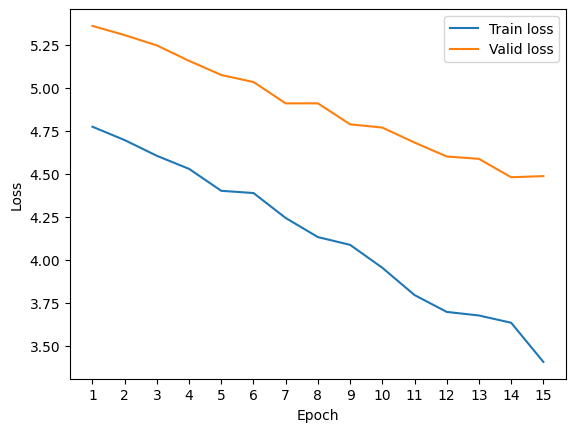

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt


x = np.arange(1, len(train_losses) + 1)
plt.plot(x, train_losses, label='Train loss')
plt.plot(x, valid_losses, label='Valid loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

In [45]:
def translate(encoder, decoder, fr_sentences, max_pred_len=50):
    sos_token_id = en_tokenizer.token_to_id('<s>')
    eos_token_id = en_tokenizer.token_to_id('</s>')
    batch_size = len(fr_sentences)

    # Pad input sentences to same length
    src_seq_lens = [len(s) for s in fr_sentences]
    max_src_len = max(src_seq_lens)
    src_padded = [s + [0] * (max_src_len - len(s)) for s in fr_sentences]
    src_tensor = tf.constant(src_padded, dtype=tf.int64)
    src_mask = tf.sequence_mask(src_seq_lens, maxlen=max_src_len, dtype=tf.bool)

    # Encode
    enc_outputs, enc_states = encoder(src_tensor, src_mask)
    dec_states = enc_states if isinstance(enc_states, tf.Tensor) else enc_states[0]

    # Init decoder input
    dec_inputs = tf.fill([batch_size], sos_token_id)

    finished = tf.zeros([batch_size], dtype=tf.bool)
    pred_ids = [[] for _ in range(batch_size)]

    for _ in range(max_pred_len):
        logits, dec_states = decoder.predict(dec_inputs, dec_states, enc_outputs, src_mask)
        predicted_ids = tf.argmax(logits, axis=-1).numpy()

        for i in range(batch_size):
            if not finished[i]:
                if predicted_ids[i] == eos_token_id:
                    finished = tf.tensor_scatter_nd_update(finished, [[i]], [True])
                else:
                    pred_ids[i].append(predicted_ids[i])

        if tf.reduce_all(finished):
            break

        dec_inputs = tf.constant(predicted_ids, dtype=tf.int64)

    return [en_tokenizer.decode(ids, skip_special_tokens=True) for ids in pred_ids]





In [68]:

test_pred = translate(model.encoder, model.decoder, test_fr)

In [72]:
np.random.seed(6666)
sample_num = 10

# Randomly sample 10 indices without replacement
indices = np.random.choice(len(test_fr), size=sample_num, replace=False)

for i, idx in enumerate(indices, 1):
    fr_text = fr_tokenizer.decode(test_fr[idx], skip_special_tokens=True)
    true_en = en_tokenizer.decode(test_en[idx], skip_special_tokens=True)
    pred_en = test_pred[idx]

    print(f"{i}.")
    print(f"French: {fr_text}")
    print(f"True English: {true_en}")
    print(f"Translated English: {pred_en}")
    print("-" * 50)


1.
French:  les bonnes équipes envoient ces informations de façon à ce que les joueurs puissent s'en servir.
True English:  the good teams stream it in a way that the players can use.
Translated English:  the good news is these kinds of information that can do with the tools to do.
--------------------------------------------------
2.
French:  merci.
True English:  thank you.
Translated English:  thank you.
--------------------------------------------------
3.
French:  il y a eu plusieurs cas où c'était vraiment juste.
True English:  there have been several close calls.
Translated English:  there were many of where it was really, it was really just just.
--------------------------------------------------
4.
French:  mes prières vous accompagnent dans votre combat.
True English:  my prayers are with you for your fight.
Translated English:  my parents will you go to your family.
--------------------------------------------------
5.
French:  et la question était : comment la technologie p

In [69]:
import evaluate
sacrebleu = evaluate.load("sacrebleu", cache_dir=dataset_path)

references = [[en_tokenizer.decode(ref, skip_special_tokens=True)] for ref in test_en]
predictions = test_pred

results = sacrebleu.compute(predictions=predictions, references=references)
print("BLEU score:", round(results["score"], 2))

BLEU score: 8.06


If you implement everything correctly, the BLEU score will be around 7.

## Conclusion (5 Points)

Including but not limited to: translation example analysis (case study), bleu score analysis, model structure / parameter analysis, etc.

Answer:

Attention is indispensable: without it, the model defaults to a single “canned” sentence for every input. Model with attention translates ALOT better.

BLEU jump (0.5 → 8.0): even simple additive attention yields a major alignment boost.

Overfitting risk: attention model shows a larger train–validation gap; add stronger regularization (dropout, label smoothing) or early stopping.


